In [2]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [3]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)

In [4]:
class Timer:  #@save
    """记录多次运行时间。"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器。"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中。"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间。"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和。"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间。"""
        return np.array(self.times).cumsum().tolist()

In [5]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'    

'0.30152 sec'

In [6]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.01166 sec'

In [7]:
def normal(x, mu, sigma):
    p = 1/math.sqrt(2*math.pi*sigma**2)
    return p*np.exp(-0.5 / sigma**2 * (x - mu)**2)

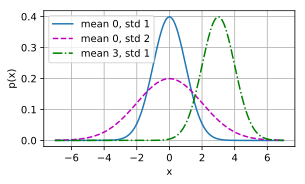

In [8]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

In [13]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [15]:
def synthetic_data(w, b, num_examples):  #@save
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [17]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([ 1.3588, -0.0701]) 
label: tensor([7.1468])


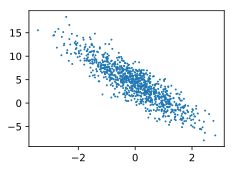

In [18]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

In [19]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size,num_examples)])
        yield features[batch_indices], labels[batch_indices]
    

In [20]:
batch_size = 10

for X,y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.5508,  0.2885],
        [-0.9309,  2.2973],
        [ 1.4965, -2.2284],
        [-0.6443, -2.0238],
        [-0.4229, -0.4959],
        [-0.2361, -1.5873],
        [ 0.3974, -0.4864],
        [-2.3010,  0.3795],
        [-0.7702,  1.3585],
        [-0.7040,  0.4968]]) 
 tensor([[ 6.3154],
        [-5.4708],
        [14.7638],
        [ 9.8040],
        [ 5.0342],
        [ 9.1351],
        [ 6.6478],
        [-1.6913],
        [-1.9611],
        [ 1.1048]])


In [21]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [22]:
w

tensor([[0.0046],
        [0.0025]], requires_grad=True)

In [26]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b
X.shape, w.shape, torch.matmul(X,w).shape, torch.matmul(X,w) == torch.mm(X,w)

(torch.Size([10, 2]), torch.Size([2, 1]), torch.Size([10, 1]), tensor([[True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True],
         [True]]))

In [27]:
def squared_loss(y_hat, y):
    return (y_hat - y.reshape(y_hat.shape))**2/2

In [28]:
def sgd(params, lr, batch_size):
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [32]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w,b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features,w,b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000049
epoch 2, loss 0.000049
epoch 3, loss 0.000050


In [33]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0002, 0.0003], grad_fn=<SubBackward0>)
b的估计误差: tensor([2.0027e-05], grad_fn=<RsubBackward1>)


3.3 线性回归的简洁实现

In [35]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)
labels.shape

torch.Size([1000, 1])

In [37]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个Pytorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)
batch_size=10
data_iter = load_array((features, labels), batch_size)

In [40]:
next(iter(data_iter))

[tensor([[ 1.2704,  0.3128],
         [-1.2018,  1.3046],
         [-1.1069, -1.9124],
         [ 1.2665, -1.6737],
         [-1.3016, -1.5887],
         [-0.9168, -1.0294],
         [-1.1321, -0.9668],
         [-1.1102,  1.4743],
         [ 0.1424,  0.4638],
         [-1.3959, -1.1130]]), tensor([[ 5.6744],
         [-2.6424],
         [ 8.4845],
         [12.4377],
         [ 7.0060],
         [ 5.8637],
         [ 5.2156],
         [-3.0299],
         [ 2.8996],
         [ 5.1928]])]

In [44]:
from torch import nn
net = nn.Sequential(nn.Linear(2,1))

In [45]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [46]:
loss = nn.MSELoss()

In [49]:
trainer = torch.optim.SGD(net.parameters(), lr = 0.3)

In [51]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        trainer.zero_grad()
        y_hat = net(X)
        l = loss(y_hat, y)
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch{epoch+1}, loss{l:f}')
        

epoch1, loss0.000107
epoch2, loss0.000118
epoch3, loss0.000105


In [58]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-0.0004, -0.0027])
b的估计误差： tensor([0.0002])


3.5.图像分类数据集

In [62]:
import torchvision
from torchvision import transforms
d2l.use_svg_display()

In [63]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root='../data', train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root='../data', train=False, transform=trans, download=True)

0it [00:00, ?it/s]

100%|█████████▉| 26378240/26421880 [01:55<00:00, 343686.51it/s] 

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



0it [00:00, ?it/s]


 56%|█████▌    | 16384/29515 [00:00<00:00, 64311.56it/s]
32768it [00:01, 52318.11it/s]                           

0it [00:00, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



 26%|██▌       | 1155072/4422102 [00:11<00:26, 122781.57it/s]
26427392it [02:10, 343686.51it/s]                              A
100%|█████████▉| 4415488/4422102 [00:29<00:00, 258028.70it/s]

0it [00:00, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw




  0%|          | 0/5148 [00:00<?, ?it/s]

8192it [00:00, 12278.99it/s]            

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!



4423680it [00:41, 258028.70it/s]                             

In [64]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [65]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [67]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签。"""
    text_labels = [
        't-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt',
        'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [68]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

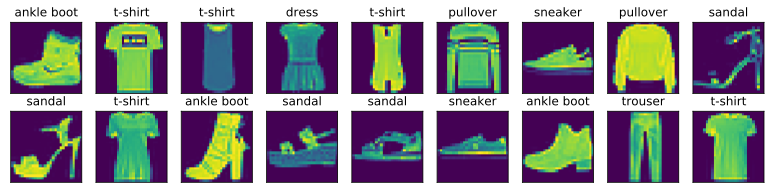

In [69]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [70]:
batch_size = 256

def get_dataloader_workers():
    """4个进程"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers())

In [71]:
timer = d2l.Timer()
for X,y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'5.60 sec'

In [72]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [73]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X,y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


3.6.softmax回归的从零开始实现

In [74]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [75]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [76]:
X = torch.tensor([[1.0,2.0,3.0],[4.0,5.0,6.0]])
X.sum(0, keepdim=True), X.sum(1,keepdim=True)

(tensor([[5., 7., 9.]]), tensor([[ 6.],
         [15.]]))

In [78]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # 这里进行广播

In [79]:
X = torch.normal(0,1,(2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1783, 0.2730, 0.2046, 0.0611, 0.2830],
         [0.1183, 0.3854, 0.3195, 0.0723, 0.1045]]), tensor([1., 1.]))

In [82]:
W.shape

torch.Size([784, 10])

In [84]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [179]:
y = torch.tensor([0,2])
y_hat = torch.tensor([[0.1,0.3,0.6],[0.3,0.2,0.5]])
y_hat[range(len(y_hat)), y]

tensor([0.1000, 0.5000])

In [138]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [141]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [142]:
accuracy(y_hat, y) / len(y)

0.5

In [144]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [145]:
class Accumulator:  #@save
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [146]:
evaluate_accuracy(net, test_iter)

0.1109

In [157]:
def train_epoch_ch3(net, train_iter, loss, updater):
    # 将模型设置为训练模型
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用Pytorch内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l)*len(y), accuracy(y_hat, y),
                y.size().numel()
            )
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [158]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [159]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [160]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W,b], lr, batch_size)

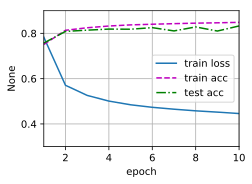

In [161]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

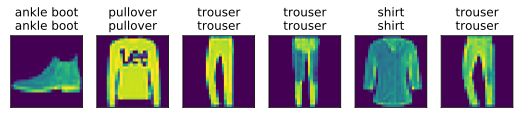

In [162]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

3.7.softmax回归的简洁实现，调接口

In [164]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [166]:
next(iter(train_iter))

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],
 
 
         [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000

In [167]:
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights);

In [168]:
loss = nn.CrossEntropyLoss()

In [169]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

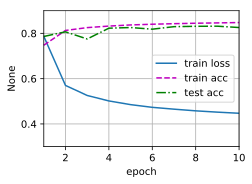

In [170]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

torch.Size([1, 5])

tensor([15])

tensor([[15]])

tensor([[0.1812, 0.4926, 1.3390, 3.6399, 9.8942]], dtype=torch.float64)

In [188]:
help(torch.nn.MaxPool2d)

Help on class MaxPool2d in module torch.nn.modules.pooling:

class MaxPool2d(_MaxPoolNd)
 |  Applies a 2D max pooling over an input signal composed of several input
 |  planes.
 |  
 |  In the simplest case, the output value of the layer with input size :math:`(N, C, H, W)`,
 |  output :math:`(N, C, H_{out}, W_{out})` and :attr:`kernel_size` :math:`(kH, kW)`
 |  can be precisely described as:
 |  
 |  .. math::
 |      \begin{aligned}
 |          out(N_i, C_j, h, w) ={} & \max_{m=0, \ldots, kH-1} \max_{n=0, \ldots, kW-1} \\
 |                                  & \text{input}(N_i, C_j, \text{stride[0]} \times h + m,
 |                                                 \text{stride[1]} \times w + n)
 |      \end{aligned}
 |  
 |  If :attr:`padding` is non-zero, then the input is implicitly zero-padded on both sides
 |  for :attr:`padding` number of points. :attr:`dilation` controls the spacing between the kernel points.
 |  It is harder to describe, but this `link`_ has a nice visualization